In [30]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = '/Users/yibeichen/Desktop/fusi/task_data'
brain_file = os.path.join(data_dir, 'Grouper_audiocue_060324_2D.nii')
event_file = os.path.join(data_dir, 'Grouper_0603_behav.mat')

# read files
brain_img = nib.load(brain_file)
brain_data = brain_img.get_fdata()
print(f"Brain data shape: {brain_data.shape}")
event_mat = sio.loadmat(event_file)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Brain data shape: (128, 1, 143, 9000)


In [3]:
# brain_img.dataobj
behave_codes = event_mat["log_temp"][:]["BehavioralCodes"][0][1:]
absolute_starttime = event_mat["log_temp"][:]["AbsoluteTrialStartTime"][0][1:]
behave_codes.shape, absolute_starttime.shape

((149,), (149,))

In [4]:
event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration', 'end'], index=range(len(behave_codes)))

for i, (c, s) in enumerate(zip(behave_codes, absolute_starttime)):
    trial_start = s[0][0]
    trial_type = c[0][0][1][2][0]
    trial_end = c[0][0][0][3] + trial_start
    stimulus_onset = c[0][0][0][2] + trial_start
    duration = stimulus_onset - trial_start + 2
    event_df.at[i, 'onset'] = stimulus_onset/1000 - 6
    event_df.at[i, 'trial_type'] = str(trial_type)
    event_df.at[i, 'duration'] = 8
    event_df.at[i, 'end'] = trial_end/1000

event_df['end'] = event_df['end'].astype(float).round(1)
event_df['onset'] = event_df['onset'].astype(float).round(1)
# event_df['onset'] = event_df['raw_onset'] - absolute_starttime[0][0]/1000

In [5]:
tr = 1/2.5
n_tr = brain_data.shape[-1]
frame_times = np.arange(n_tr) * tr

In [6]:
event_binary_df = pd.DataFrame(index=frame_times.round(1))

def find_nearest_index(value, index, tolerance=0.1):
    diffs = np.abs(index - value)
    nearest_idx = diffs.argmin()
    nearest_value = index[nearest_idx]
    
    print(f"Value: {value}, Nearest Index: {nearest_value}, Diff: {diffs[nearest_idx]}")
    
    if np.isclose(diffs[nearest_idx], 0, atol=tolerance):
        return nearest_value
    return None

for i, row in event_df.iterrows():
    nearest_index_onset = find_nearest_index(row['onset'], event_binary_df.index, tolerance=0.20)
    nearest_index_end = find_nearest_index(row['end'], event_binary_df.index, tolerance=0.20)
    event_df.at[i, 'nearest_index_onset'] = nearest_index_onset
    event_df.at[i, 'nearest_index_end'] = nearest_index_end
    if row['end'] < event_binary_df.index[-1]:
        if nearest_index_onset is not None and nearest_index_end is not None:
            existing_values = event_binary_df.loc[nearest_index_onset:nearest_index_end, :]
            if (existing_values == 1).any().any():
                print(f"Overlap detected for trial {row['trial_type']} at indices {nearest_index_onset}:{nearest_index_end}")
            else:
                event_binary_df.loc[nearest_index_onset:nearest_index_end, row['trial_type']] = 1
                print(f"Assigned 1s from {nearest_index_onset} to {nearest_index_end} for trial {row['trial_type']}")
        else:
            print(f"No suitable index found for onset: {row['onset']} or end: {row['end']} for trial {row['trial_type']}")
    else:
        if nearest_index_onset is not None:
            existing_values = event_binary_df.loc[nearest_index_onset:, :]
            if (existing_values == 1).any().any():
                print(f"Overlap detected for trial {row['trial_type']} at indices {nearest_index_onset}:{nearest_index_end}")
            else:
                event_binary_df.loc[nearest_index_onset:, row['trial_type']] = 1
                print(f"Assigned 1s from {nearest_index_onset} to {nearest_index_end} for trial {row['trial_type']}")
        else:
            print(f"No suitable index found for onset: {row['onset']} or end: {row['end']} for trial {row['trial_type']}")

event_binary_df.rename(columns={'5':'reward', '6':'airpuff', '7':'idle'}, inplace=True)

Value: 46.9, Nearest Index: 46.8, Diff: 0.10000000000000142
Value: 71.9, Nearest Index: 72.0, Diff: 0.09999999999999432
Assigned 1s from 46.8 to 72.0 for trial 6
Value: 72.8, Nearest Index: 72.8, Diff: 0.0
Value: 94.0, Nearest Index: 94.0, Diff: 0.0
Assigned 1s from 72.8 to 94.0 for trial 5
Value: 94.8, Nearest Index: 94.8, Diff: 0.0
Value: 119.9, Nearest Index: 120.0, Diff: 0.09999999999999432
Assigned 1s from 94.8 to 120.0 for trial 5
Value: 120.8, Nearest Index: 120.8, Diff: 0.0
Value: 141.9, Nearest Index: 142.0, Diff: 0.09999999999999432
Assigned 1s from 120.8 to 142.0 for trial 5
Value: 142.6, Nearest Index: 142.4, Diff: 0.19999999999998863
Value: 167.7, Nearest Index: 167.6, Diff: 0.09999999999999432
Assigned 1s from 142.4 to 167.6 for trial 5
Value: 170.6, Nearest Index: 170.4, Diff: 0.19999999999998863
Value: 191.6, Nearest Index: 191.6, Diff: 0.0
Assigned 1s from 170.4 to 191.6 for trial 7
Value: 192.4, Nearest Index: 192.4, Diff: 0.0
Value: 213.5, Nearest Index: 213.6, Diff:

In [7]:
event_df1 = event_df.dropna(subset=['nearest_index_onset'])
event_df1.at[event_df1.index[-1], 'nearest_index_end'] =event_binary_df.index[-1]
event_df1

,onset,trial_type,duration,end,nearest_index_onset,nearest_index_end
0,46.9,6,8,71.9,46.8,72.0
1,72.8,5,8,94.0,72.8,94.0
2,94.8,5,8,119.9,94.8,120.0
3,120.8,5,8,141.9,120.8,142.0
4,142.6,5,8,167.7,142.4,167.6
...,...,...,...,...,...,...
141,3479.6,6,8,3504.6,3479.6,3504.4
142,3507.4,7,8,3528.4,3507.6,3528.4
143,3531.0,7,8,3556.1,3530.8,3556.0
144,3556.8,5,8,3581.9,3556.8,3582.0


In [8]:
Y = brain_data.reshape(-1, brain_data.shape[-1])

In [ ]:
data_df = pd.DataFrame(Y.T, columns=np.arange(Y.shape[0]), index=frame_times.round(1))

In [ ]:

def get_psth_task_data(data_df, event_df1, trial_type, has_cue=0, tr=1/2.5):
    psth_task_df = pd.DataFrame(columns=np.arange(data_df.shape[1]), index=data_df.index)
    sub_df = event_df1[event_df1['trial_type'] == str(trial_type)]

    for i, row in sub_df.iterrows():
        if has_cue == 0: # no cue, stimulus only
            nearest_index_onset = row['nearest_index_onset'] + tr * 6
            nearest_index_end = nearest_index_onset + tr * 2
        elif has_cue == 1: # cue only
            nearest_index_onset = row['nearest_index_onset'] 
            nearest_index_end = nearest_index_onset + tr * 2
        elif has_cue == 2: # cue + stimulus
            nearest_index_onset = row['nearest_index_onset'] + tr * 6
            nearest_index_end = nearest_index_onset + tr * 8
        else:
            raise ValueError("has_cue must be 0, 1, or 2")
        
        # Ensure index range is within bounds
        start_idx = max(nearest_index_onset - tr * 5, 0)
        
        # Calculate baseline data using np.nanmean to ignore NaNs
        baseline_data = np.nanmean(data_df.loc[start_idx:nearest_index_onset, :], axis=0)
        # print(f"baseline_data shape: {baseline_data.shape}")
        
        # Calculate task data, again handling NaNs
        # task_data = (data_df.loc[nearest_index_onset:nearest_index_end, :] - baseline_data) / baseline_data
        task_data = data_df.loc[nearest_index_onset:nearest_index_end, :]
        
        # Assign to psth_task_df, ensuring alignment
        psth_task_df.loc[nearest_index_onset:nearest_index_end, :] = task_data.values

    return psth_task_df.apply(pd.to_numeric, errors='coerce')


In [ ]:
# no cue, stimulus only
psth_reward_stim_data = get_psth_task_data(data_df, event_df1, 5, has_cue=0)
psth_airpuff_stim_data = get_psth_task_data(data_df, event_df1, 6, has_cue=0)
psth_idle_stim_data = get_psth_task_data(data_df, event_df1, 7, has_cue=0)

# cue only
psth_reward_cue_data = get_psth_task_data(data_df, event_df1, 5, has_cue=1)
psth_airpuff_cue_data = get_psth_task_data(data_df, event_df1, 6, has_cue=1)
psth_idle_cue_data = get_psth_task_data(data_df, event_df1, 7, has_cue=1)

# cue + stimulus
psth_reward_data = get_psth_task_data(data_df, event_df1, 5, has_cue=2)
psth_airpuff_data = get_psth_task_data(data_df, event_df1, 6, has_cue=2)
psth_idle_data = get_psth_task_data(data_df, event_df1, 7, has_cue=2)

In [ ]:
def reformat_data(df):
    return np.nanmean(df.values, axis=0).reshape(128,143).T

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()
all_data = [psth_reward_stim_data, psth_airpuff_stim_data, psth_idle_stim_data, 
            psth_reward_cue_data, psth_airpuff_cue_data, psth_idle_cue_data,
            psth_reward_data, psth_airpuff_data, psth_idle_data]
titles = ['Reward Stim', 'Airpuff Stim', 'Idle Stim', 'Reward Cues', 'Airpuff Cues', 'Idle Cues', 'Reward Stim + Cues', 'Airpuff Stim + Cues', 'Idle Stim + Cues']

for i, ax in enumerate(axes):
    sns.heatmap(reformat_data(all_data[i]), ax=ax, cmap="bwr")
    ax.set_xlim(25, 35)
    ax.set_ylim(25, 35)
    ax.set_title(titles[i])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
plt.imshow(reformat_data(psth_reward_stim_data) - reformat_data(psth_idle_stim_data), cmap='bwr')
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(reformat_data(psth_reward_cue_data) - reformat_data(psth_idle_cue_data), cmap='bwr')
plt.colorbar()
plt.show()

In [ ]:
sns.lineplot(brain_data[25,:,25,:])
plt.show()

In [ ]:

def get_psth_task_data(data_df, event_df1, trial_type, has_cue=0, tr=1/2.5):
    psth_task_df = pd.DataFrame(columns=np.arange(data_df.shape[1]), index=data_df.index)
    sub_df = event_df1[event_df1['trial_type'] == str(trial_type)]

    for i, row in sub_df.iterrows():
        if has_cue == 0: # no cue, stimulus only
            nearest_index_onset = row['nearest_index_onset'] + 6/tr
            nearest_index_end = nearest_index_onset + 2/tr
        elif has_cue == 1: # cue only
            nearest_index_onset = row['nearest_index_onset'] 
            nearest_index_end = nearest_index_onset + 2/tr
        elif has_cue == 2: # cue + stimulus
            nearest_index_onset = row['nearest_index_onset'] + 6/tr
            nearest_index_end = nearest_index_onset + 8/tr
        else:
            raise ValueError("has_cue must be 0, 1, or 2")
        
        # Ensure index range is within bounds
        start_idx = max(nearest_index_onset - 5/tr, 0)
        
        # Calculate baseline data using np.nanmean to ignore NaNs
        baseline_data = np.nanmean(data_df.loc[start_idx:nearest_index_onset, :], axis=0)
        # print(f"baseline_data shape: {baseline_data.shape}")
        
        # Calculate task data, again handling NaNs
        task_data = (data_df.loc[nearest_index_onset:nearest_index_end, :] - baseline_data) / baseline_data
        # task_data = data_df.loc[nearest_index_onset:nearest_index_end, :]
        
        # Assign to psth_task_df, ensuring alignment
        psth_task_df.loc[nearest_index_onset:nearest_index_end, :] = task_data.values

    return psth_task_df.apply(pd.to_numeric, errors='coerce')

In [28]:
# def get_trial_data(event_df, pixel_df, tr=1/2.5):
#     trial_data_df = event_df.copy(deep=True)
#     # Initialize columns to hold the expanded data
#     for col in range(pixel_df.shape[1]):
#         trial_data_df[f'data_col_{col}'] = None

#     for i, r in trial_data_df.iterrows():
#         data = pixel_df.loc[r['nearest_index_onset']-12*tr:r['nearest_index_onset']+48*tr, :].values.flatten()
#         # print(i, r['nearest_index_onset'], data.size)
#         for j in range(data.size):
#             trial_data_df.at[i, f'time_{j}'] = data[j]
#     trial_data_df = trial_data_df.loc[trial_data_df.index[:-1]]

#     return trial_data_df

def get_trial_data(event_df, pixel_data, tr=1/2.5):
    # Prepare the offsets in terms of time units (no conversion to int required)
    offset_start = -12 * tr
    offset_end = 48 * tr

    # Precompute the index ranges for all trials using np.arange
    onset_indices = event_df['nearest_index_onset'].values
    indices = [np.arange(i + offset_start, i + offset_end, step=tr) for i in onset_indices]

    # Determine the consistent length for slices
    slice_length = len(indices[0]) * pixel_data.shape[1]

    # Initialize the trial data array with the consistent slice length
    trial_data = np.full((len(event_df), slice_length), np.nan)

    # Populate the trial data array
    for i, idx_range in enumerate(indices):
        valid_idx_range = (idx_range / tr).astype(int)
        valid_idx_range = valid_idx_range[(valid_idx_range >= 0) & (valid_idx_range < pixel_data.shape[0])]
        
        # Flatten the pixel data and ensure the length matches the expected slice length
        data = pixel_data[valid_idx_range, :].flatten()
        if len(data) > slice_length:
            data = data[:slice_length]  # Truncate if too long
        elif len(data) < slice_length:
            data = np.pad(data, (0, slice_length - len(data)), 'constant', constant_values=np.nan)  # Pad if too short
        
        trial_data[i, :len(data)] = data

    return trial_data

In [10]:
# def normalize_data(data_df):
#     baseline_cols = [f"time_{i}" for i in range(0, 12, 1)]
#     baseline_data = np.nanmean(data_df[baseline_cols].values, axis=1)

#     baseline_data = baseline_data[:, np.newaxis]

#     task_cols = [f"time_{i}" for i in range(0, 61, 1)]
#     task_data = (np.array(data_df[task_cols].values) - baseline_data) / baseline_data

#     return task_data

def normalize_data(data):
    baseline = np.nanmean(data[:, :12], axis=1, keepdims=True)
    task_data = (data - baseline) / baseline
    return task_data


In [11]:
def proc_pixel(pixel_data, event_df, tr=1/2.5):
    trial_data = get_trial_data(event_df, pixel_data, tr)
    reward_data = trial_data[event_df['trial_type'] == '5']
    airpuff_data = trial_data[event_df['trial_type'] == '6']
    idle_data = trial_data[event_df['trial_type'] == '7']

    reward_data_normalized = normalize_data(reward_data)
    airpuff_data_normalized = normalize_data(airpuff_data)
    idle_data_normalized = normalize_data(idle_data)

    return reward_data_normalized, airpuff_data_normalized, idle_data_normalized

In [12]:
def get_trial_mean(data, start, end):
    return np.nanmean(data[:, start:end], axis=(0,1))

In [29]:
i = 25
pixel_data = Y[i, :].reshape(-1, 1)  # Ensure pixel_data is 2D
reward_data_normalized, airpuff_data_normalized, idle_data_normalized = proc_pixel(pixel_data, event_df1)

In [31]:
cue_activation_normalized = np.zeros((len(Y), 3))
stimulus_activation_normalized = np.zeros((len(Y), 3))

for i in tqdm(range(len(Y)), desc="Processing Pixels"):
    pixel_data = Y[i, :].reshape(-1, 1)  # Ensure pixel_data is 2D
    reward_data_normalized, airpuff_data_normalized, idle_data_normalized = proc_pixel(pixel_data, event_df1)

    cue_activation_normalized[i, 0] = get_trial_mean(reward_data_normalized, 12, 24)
    cue_activation_normalized[i, 1] = get_trial_mean(airpuff_data_normalized, 12, 24)
    cue_activation_normalized[i, 2] = get_trial_mean(idle_data_normalized, 12, 24)
    
    stimulus_activation_normalized[i, 0] = get_trial_mean(reward_data_normalized, 24, 50)
    stimulus_activation_normalized[i, 1] = get_trial_mean(airpuff_data_normalized, 24, 50)
    stimulus_activation_normalized[i, 2] = get_trial_mean(idle_data_normalized, 24, 50)

Processing Pixels: 100%|██████████| 18304/18304 [00:15<00:00, 1195.95it/s]


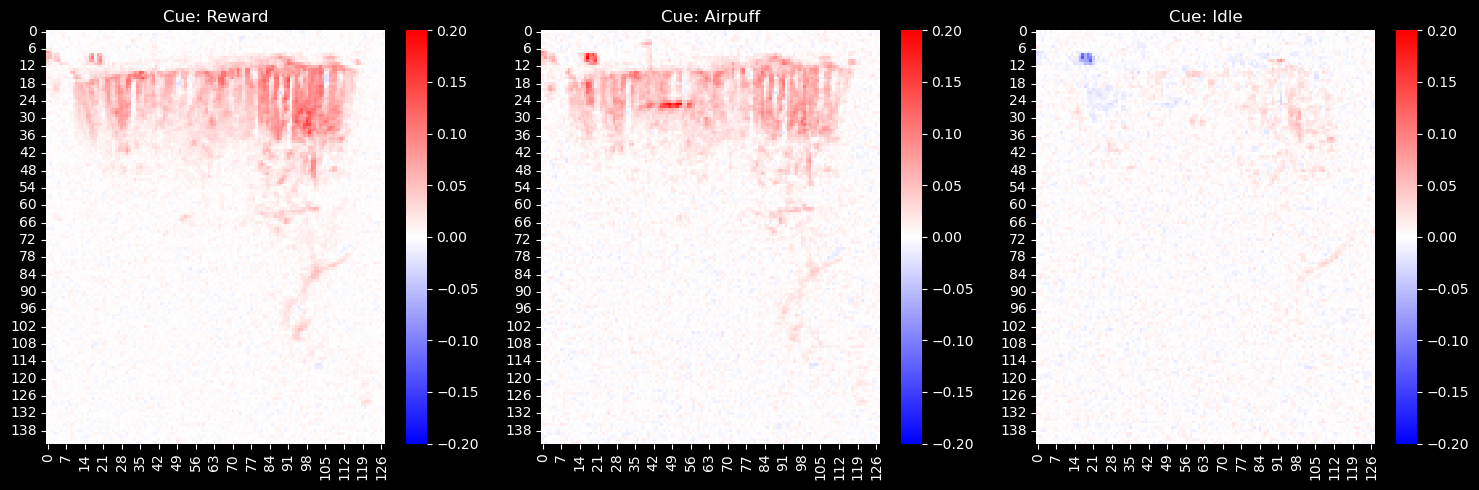

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

tasks = ['Reward', 'Airpuff', 'Idle']
# Iterate over the dictionary and plot each heatmap
for i in range(3):
    
    sns.heatmap(cue_activation_normalized[:, i].reshape(128, 143).T, ax=axes[i], cmap="bwr", vmin=-0.2, vmax=0.2)
    axes[i].set_title(f"Cue: {tasks[i]}")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

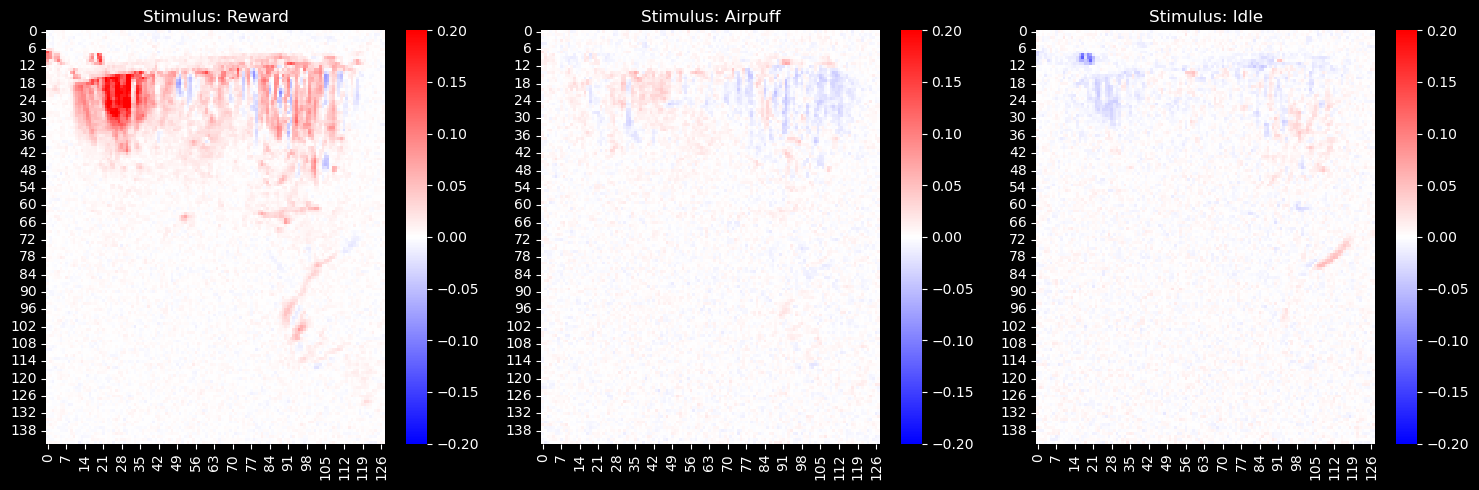

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

tasks = ['Reward', 'Airpuff', 'Idle']
# Iterate over the dictionary and plot each heatmap
for i in range(3):
    
    sns.heatmap(stimulus_activation_normalized[:, i].reshape(128, 143).T, ax=axes[i], cmap="bwr", vmin=-0.2, vmax=0.2)
    axes[i].set_title(f"Stimulus: {tasks[i]}")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

In [ ]:
trial_data_df.columns[7:]

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

cols = trial_data_df.columns[7:]
fig = plt.figure(figsize=(12, 25))

# Use GridSpec to control the layout
gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0.1)

# First plot (main data)
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(trial_data_df[cols].values, cmap='coolwarm', aspect='auto')
# ax0.set_xticks(np.arange(0, 20, 1))
# ax0.set_xticklabels(np.arange(-5, 15, 1))
ax0.set_ylabel('Trial')

# Discrete colormap for trial_type
cmap = ListedColormap(['red', 'green', 'blue'])

# Second plot (trial type) placed to the right of the first plot
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(trial_data_df['trial_type'].values.astype(int).reshape(-1, 1), cmap=cmap, aspect='auto')
ax1.set_xticks([])
ax1.set_yticks([])

plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
cbar = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Airpuff', 'Reward', 'idle'])  # Custom labels

plt.show()

In [ ]:
reward_data = trial_data_df[trial_data_df['trial_type'] == '5']
airpuff_data = trial_data_df[trial_data_df['trial_type'] == '6']
idle_data = trial_data_df[trial_data_df['trial_type'] == '7']

In [ ]:
cols = trial_data_df.columns[7:]
fig = plt.figure(figsize=(18, 25))  # Adjust the figure size to accommodate three plots

# Use GridSpec to control the layout
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.1)  # Three equal-width plots

# First plot (reward_data)
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(reward_data[cols].values, cmap='coolwarm', aspect='auto')
ax0.set_title('Reward Data')
ax0.set_ylabel('Trial')
# ax0.set_xticks([])  # Adjust or remove ticks as needed

# Second plot (airpuff_data)
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(airpuff_data[cols].values, cmap='coolwarm', aspect='auto')
ax1.set_title('Airpuff Data')
# ax1.set_xticks([])  # Adjust or remove ticks as needed
# ax1.set_yticks([])

# Third plot (idle_data)
ax2 = fig.add_subplot(gs[2])
im2 = ax2.imshow(idle_data[cols].values, cmap='coolwarm', aspect='auto')
ax2.set_title('Idle Data')
# ax2.set_xticks([])  # Adjust or remove ticks as needed
# ax2.set_yticks([])

# Add colorbars (optional)
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.show()

In [ ]:
def normalize_data(data_df):
    baseline_cols = [f"time_{i}" for i in range(0, 12, 1)]
    baseline_data = np.nanmean(data_df[baseline_cols].values, axis=1)

    baseline_data = baseline_data[:, np.newaxis]

    task_cols = [f"time_{i}" for i in range(0, 61, 1)]
    task_data = (np.array(data_df[task_cols].values) - baseline_data) / baseline_data

    return task_data

In [ ]:
reward_data_normalized = normalize_data(reward_data)
airpuff_data_normalized = normalize_data(airpuff_data)
idle_data_normalized = normalize_data(idle_data)

In [ ]:
cols = trial_data_df.columns[7:]
fig = plt.figure(figsize=(18, 25))  # Adjust the figure size to accommodate three plots

# Use GridSpec to control the layout
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.1)  # Three equal-width plots

# First plot (reward_data)
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(reward_data_normalized, cmap='coolwarm', aspect='auto')
ax0.set_title('Reward Data')
ax0.set_ylabel('Trial')
# ax0.set_xticks([])  # Adjust or remove ticks as needed

# Second plot (airpuff_data)
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(airpuff_data_normalized, cmap='coolwarm', aspect='auto')
ax1.set_title('Airpuff Data')
# ax1.set_xticks([])  # Adjust or remove ticks as needed
# ax1.set_yticks([])

# Third plot (idle_data)
ax2 = fig.add_subplot(gs[2])
im2 = ax2.imshow(idle_data_normalized, cmap='coolwarm', aspect='auto')
ax2.set_title('Idle Data')
# ax2.set_xticks([])  # Adjust or remove ticks as needed
# ax2.set_yticks([])

# Add colorbars (optional)
plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.show()

In [ ]:
reward_data_normalized = normalize_data(reward_data)
airpuff_data_normalized = normalize_data(airpuff_data)
idle_data_normalized = normalize_data(idle_data)

In [ ]:
reward_data_normalized.shape

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the three lines
plt.plot(np.nanmean(reward_data_normalized, axis=0), label='Reward')  
plt.plot(np.nanmean(airpuff_data_normalized, axis=0), label='Airpuff', alpha=0.5) 
plt.plot(np.nanmean(idle_data_normalized, axis=0), label='Idle', alpha=0.5) # Third line

# # Adding titles and labels
# plt.title('Three Lines in One Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')

# Add a legend
plt.legend()

# Show the plot
plt.show()